In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima import auto_arima

In [2]:
stock_prices=pd.read_csv("/content/TSLA (3).csv",usecols=["Date","Close"])
stock_prices["Date"]=pd.to_datetime(stock_prices["Date"],infer_datetime_format=True)
stock_prices2=stock_prices["Date"]
stock_prices.set_index(["Date"],inplace=True)

In [3]:
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2956 non-null   float64
dtypes: float64(1)
memory usage: 46.2 KB


In [4]:
stock_prices.isnull().sum()

Close    0
dtype: int64

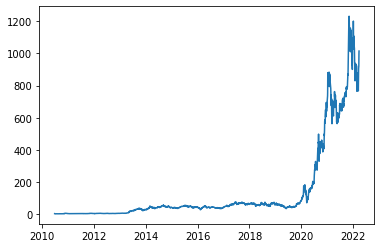

In [5]:
plt.plot(stock_prices)
plt.show()

Increasing trend
No seasonality


SMA

In [6]:
sma=stock_prices.rolling(window=30).mean()
smv=stock_prices.rolling(window=30).std()
print(sma[29:])
print(smv[29:])

                 Close
Date                  
2010-08-10    4.008267
2010-08-11    3.968333
2010-08-12    3.926800
2010-08-13    3.902533
2010-08-16    3.899733
...                ...
2022-03-18  856.655998
2022-03-21  856.583997
2022-03-22  859.471995
2022-03-23  862.042328
2022-03-24  864.772994

[2927 rows x 1 columns]
                Close
Date                 
2010-08-10   0.387445
2010-08-11   0.366549
2010-08-12   0.342877
2010-08-13   0.334476
2010-08-16   0.335368
...               ...
2022-03-18  48.145209
2022-03-21  48.043583
2022-03-22  53.494652
2022-03-23  58.244276
2022-03-24  63.335049

[2927 rows x 1 columns]


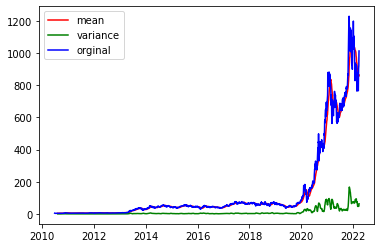

In [7]:
plt.plot(sma,color="red",label="mean")
plt.plot(smv,color="green",label="variance")
plt.plot(stock_prices,color="blue",label="orginal")
plt.legend()
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(stock_prices["Close"], autolag='AIC')
print(result)

(1.4239415939225972, 0.9972202364261444, 28, 2927, {'1%': -3.4325860929804404, '5%': -2.8625279573644873, '10%': -2.5672959172141048}, 22241.284192789386)


Mean not constant
variance almost constant
data is not stationary

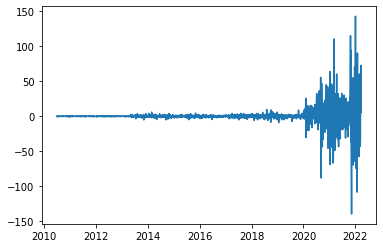

In [9]:
stock_prices1=stock_prices.diff(periods=1)
plt.plot(stock_prices1)

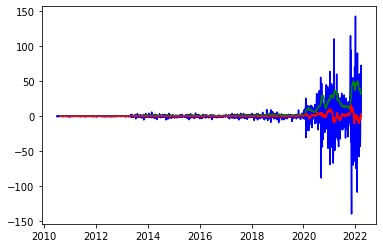

In [10]:
stock_prices1.dropna(inplace=True)
sma=stock_prices1.rolling(window=30).mean()
smv=stock_prices1.rolling(window=30).std()
plt.plot(stock_prices1,color="blue",label="orginal")
plt.plot(smv,color="green",label="variance")
plt.plot(sma,color="red",label="mean")

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(stock_prices1["Close"], autolag='AIC')
print(result)

(-9.844955339484892, 4.646088212091373e-17, 28, 2926, {'1%': -3.432586857867417, '5%': -2.862528295182304, '10%': -2.567296097065506}, 22234.38709932327)


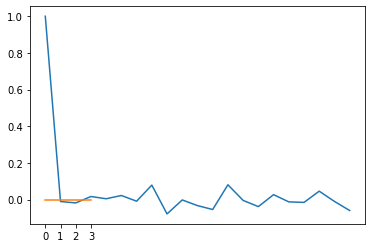

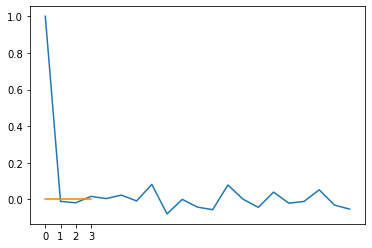

In [12]:
from statsmodels.tsa.stattools import acf, pacf
p=acf(stock_prices1,nlags=20)
plt.plot(p)
plt.xticks([0,1,2,3])
plt.plot([0,1,2,3],[0,0,0,0])
plt.show()
q=pacf(stock_prices1,nlags=20,method='ols')
plt.plot(q)
plt.xticks([0,1,2,3])
plt.plot([0,1,2,3],[0,0,0,0])
plt.show()


p=1

q=1

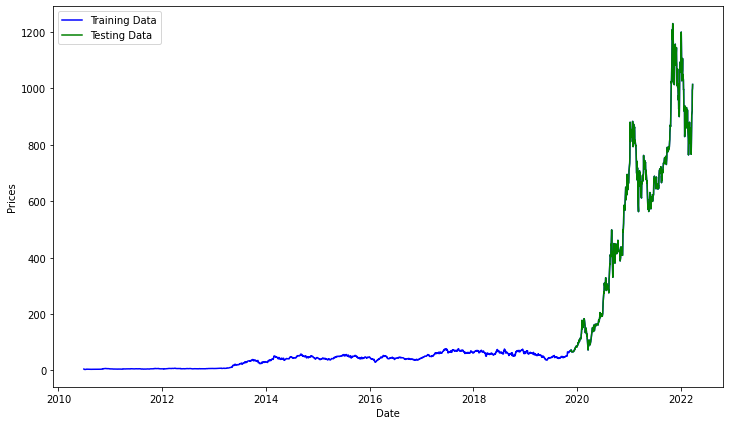

In [13]:
start=int(len(stock_prices)*0.8)
train, test = stock_prices[:start], stock_prices[start:]
plt.figure(figsize=(12,7))
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(stock_prices['Close'], 'blue', label='Training Data')
plt.plot(test['Close'], 'green', label='Testing Data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7746.116, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7748.055, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7748.055, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7745.293, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7750.055, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.103 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2364
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3871.646
Date:                Wed, 29 Jun 2022   AIC                           7745.293
Time:                        13:33:32   BIC                           7751.061
Sample:                             0   HQIC                          7747.393
                               - 2364                                       

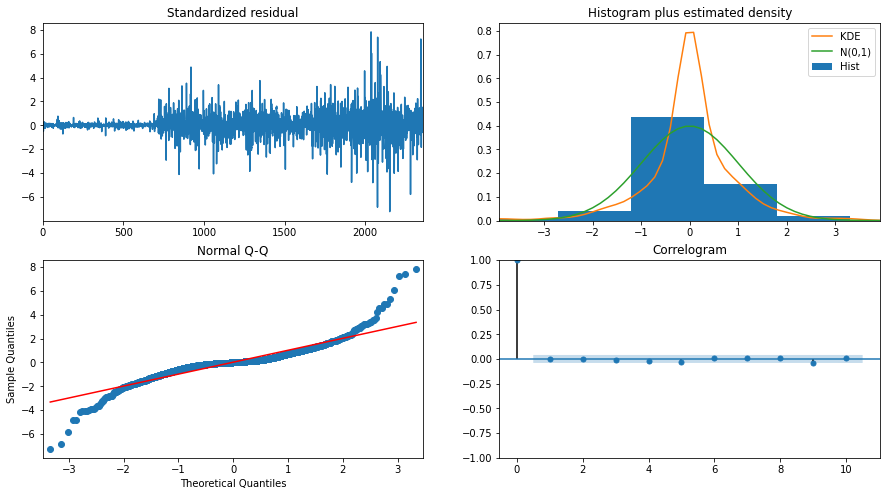

In [14]:
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [15]:
from statsmodels.tsa.arima.model import ARIMA


In [20]:
train_ar = train['Close'].values
test_ar = test['Close'].values
history = [x for x in train_ar]
predictions = []
for t in range(len(test_ar)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    y = output[0]
    predictions.append(y)
    history.append(test_ar[t])
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [21]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test,predictions)

0.03229201342080025

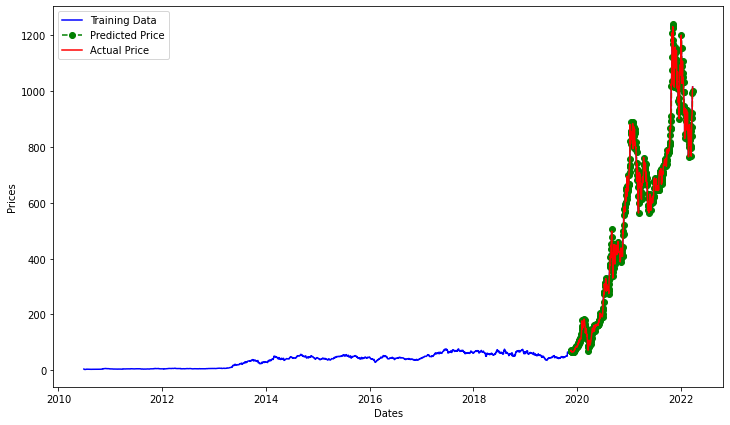

In [22]:
plt.figure(figsize=(12,7))
plt.plot(stock_prices['Close'], 'green', color='blue', label='Training Data')
plt.plot(test.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test.index, test['Close'], color='red', label='Actual Price')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()